In [256]:
import numpy as np
import matplotlib.pyplot as plt 
import wave
from scipy.io import wavfile
import IPython.display as ipd
from IPython.display import display,Audio
from scipy.signal import firwin

# **Découpage en trames de 20 ms**

16000


'Te=1/fe\n\n#On a 320 échantillons par trames \nplt.plot(y[2])'

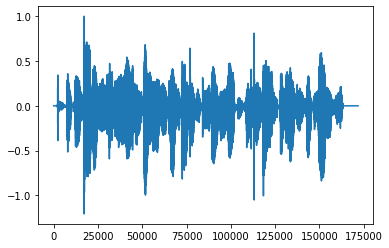

In [257]:
#Découper le fichier en trames de 20 ms

samplerate, data = wavfile.read('voice.wav')
print(samplerate)
Fe=8000

if len(np.shape(data))>1:

  data = data.sum(axis=1) / 2  # si le signalest ne stereo on rememt en mono 
data=data+0.00000000001


display(Audio(data,rate=samplerate))
#durée du signal sonore en secondes
T=len(data)/Fe
#Nombre d'échantillons dans chaque trame
n=int(20*10**(-3)*Fe)
data=np.array(data)/max(data)
plt.plot(data)
#Découpage en trames
"""Te=1/fe

#On a 320 échantillons par trames 
plt.plot(y[2])"""

160
1074
1074


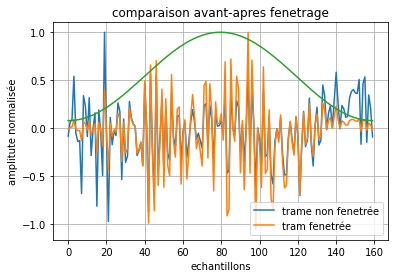

In [258]:
##Nwin : taille de la fenetre d' analyse 
#Nhop= le pas d avanceement 
#nfft : nombre de points utilisé pour la TFD 
Te=1/Fe

Nwin=int(0.02/Te)
print(Nwin)
Nhop=Nwin
nb_trames=int(np.ceil(len(data)/Nhop))
#a=int(np.ceil(len(data)/Nhop))-(len(data)/Nhop)
#ajout_zero=int(a*Nwin)


print(nb_trames)
dattaa=[]
y=[]
nfft=Nwin
data=np.concatenate((data,np.zeros(nfft)))
for i in range(nb_trames):
  c_hop=Nhop*i
  segment=data[c_hop:c_hop+nfft]
  sig_fen=segment*np.hamming(nfft)
  dattaa.append(segment)
  y.append(sig_fen)

print(len(dattaa))
plt.figure()
plt.plot(dattaa[200]/max(dattaa[200]),label='trame non fenetrée')
plt.plot(y[200]/max(y[200]),label='tram fenetrée')
plt.plot(np.hamming(Nwin))
plt.title("comparaison avant-apres fenetrage")
plt.xlabel("echantillons")
plt.ylabel('amplitute normalisée')
plt.legend()
plt.grid()


# **Méthode LPC**

In [259]:
#LPC pour chaque trame

#Calcule des coefficients R(p)
def R(j,p):   #j représente le numéro de la trame, cette fonction calcule le coeff R(p) de la j ème trame
  r=0
  N=len(y[j])-p
  for i in range(N):
    r+=y[j][i]*y[j][i+p]
  return r

def LPC (j,P):       #Résoudre A*a=r, j représente le numéro de la trame
  r=np.zeros((P, 1))
  for i in range (P):
    r[i][0]=R(j,i+1)
  
  A=np.zeros((P, P))
  for i in range (P):
    #Valeurs sur la diagonale
    A[i][i] = R(j,0)
  #Valeurs au dessus de la diagonale 
  for i in range (P):
    for k in range (P):
      if (i+k<P):
        #A[0+k][i+k] = A[0][i]
        A[0+k][i+k] = R(j,i)      
  #Ensuite pour toute valeur de la matrice en dessous de la diagonale faire = à son symétrique
  for i in range (P):
    for k in range (P):
      if(i+k<P):
        A[i+k][k] = A[k][i+k]
  return A,r

# **Tracé du filtre du conduit vocal**

In [260]:
#Transformé en Z des la fonction du filtre des conduits vocaux 
def H(z):
  P=len(x)
  den=0
  for i in range(P):
    den+=x[i]*z**(-i-1)
    
  return 1/(1-den)
### de TZ A LA TFD
def Hf(f): # calcule de la fontion de transfert du filtre 
    return H(np.exp(1j*2*math.pi*f))

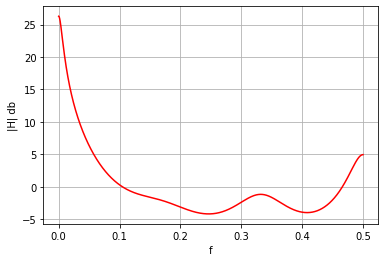

In [261]:
import math
import cmath
#visulations des coefficiton du filtre 
f = np.arange(start=0,stop=0.5,step=0.000125)
plt.plot(f,20*np.log10(np.absolute(Hf(f))),'r')
plt.xlabel('f')
plt.ylabel('|H| db')
plt.grid()
plt.show()



In [262]:
def Y(z):
  N=len(y[215])
  s=0
  for i in range (N):
    s+=y[200][i]*z**(-i-1)
  return s

def Yf(f):
  return  Y(np.exp(1j*2*math.pi*f))

def e(z):
  return Y(z)/H(z)

def ef(f):
  return e(np.exp(1j*2*math.pi*f/Fe))

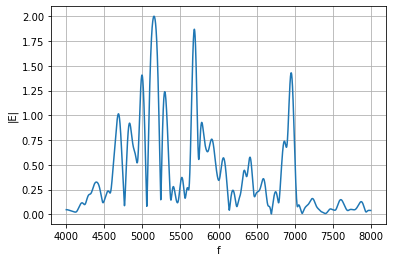

In [263]:
f = np.arange(start=Fe/2,stop=Fe,step=1)
# visulation de la reponse frequancielle du signal d entrée 
plt.plot(f,np.absolute(ef(f)))
plt.xlabel('f')
plt.ylabel('|E|')
plt.grid()

# **Extraire la fréquence fondamentale**

In [264]:
def frequence(ef):# extrction de la frenqeunce fondamontale 
      freqs = np.fft.fftfreq(len(ef(f)))
      #print(freqs.min(),freqs.max())
      idx = np.argmax(np.abs(ef(f)))
      #print(idx)
      freq = freqs[idx]
      freq_in_hertz = abs(freq * Fe)
      return freq_in_hertz



In [265]:
def sigma(trame,P,x,Fe):# calcule de sigma pour chaque tram 
  N=0.02*Fe
  s=0
  for i in range (len(y[trame])):
    s1=0
    tr=y[trame]
    for k in range (P):
      
      s1+=x[k]*tr[i-k]

    s+=(y[i]*s1)**2
  sigma=np.sqrt(s/N)
  return sigma

In [266]:
def get_note(frequance ): # calcule de la note la plus proche la la frequance extraite 
    k=2**(1/12)
    la3=440 #reference 
    
    x=round((math.log(frequance+0.0000001)-math.log(la3))/math.log(k))
    # notelist=["do or si#","do♯ ou ré♭","ré","ré♯ ou mi♭	","mi ou fa♭","fa ou mi♯","fa♯ ou sol♭","sol","sol♯ ou la♭","la","la♯ ou si♭","si ou do♭"]
    # temp=9
    # index=temp+x
    # print( index)
    # for i  in in range(84)
    #     if index<0:
    #         index=11
    #     elif index>11:
    #         index=0
   
    # note=notelist[index]
    
    # prin
    freq= la3*k**(x)
    return (freq)





________________________________________________________________________________

In [267]:




######################### main ##################################
      #################################################
   
ordre=8 # ordre de la LPC
signal=[]
for i in range(len(y)):
    A,b=LPC(i,ordre) 
    #calcule des matrice a laide de l'agorythme LPC 
    Rinv= np.linalg.inv(A) 
    x=np.dot(Rinv,b)# EXTRACION DES COEFFISIONS DES FILTRES 
    f = np.arange(start=0,stop=0.5,step=1/(2*len(y[i])))
    freq_in_hertz=frequence(ef) # CALCULE DE LA FREQUANCE FONDAMENTALE DE CHAQUE TRAME 
    new_f= get_note(freq_in_hertz) # CALCULE DE LA FREQAUNCE DE LA NOTE MUSICALE  LA PLUS PROCHE  A LA FREQUANCE DE CETTE TRAM 
    N=len(y[i])
    te=np.linspace(0,(N-1)/new_f,N)
    sigm=sigma(i,ordre,x,Fe) # CALCULE DU GAIN SIGMA 
    
    sing=np.absolute(np.sin(2. * np.pi *te/0.02)) #CREATION DUN SIGNAL D'EXITATION  AVEC LA NOUVELLE FREQUANCE               
    singfft=np.fft.fft(sing) # CALCULE DE SA TRANSFORME DE FOURIER 
    new_exit=singfft*Hf(f)#LA FITLER AVEC LE FILRE X[F]*H[F]=Y[F]
    audio=np.fft.ifft(new_exit)*sigm #RECUPERATION DU SIGNAL DE LA TRAME EN TEMPS  PUIS LE MUTITIPLIER PAR LE GAIN OBTENU PAR SIGMA
    for j in range(len(audio)):
      audio[j]=audio[j]*np.sign(y[i][j])
      
    signal.extend(np.real(audio))






--------------------------------------------------------------------------------

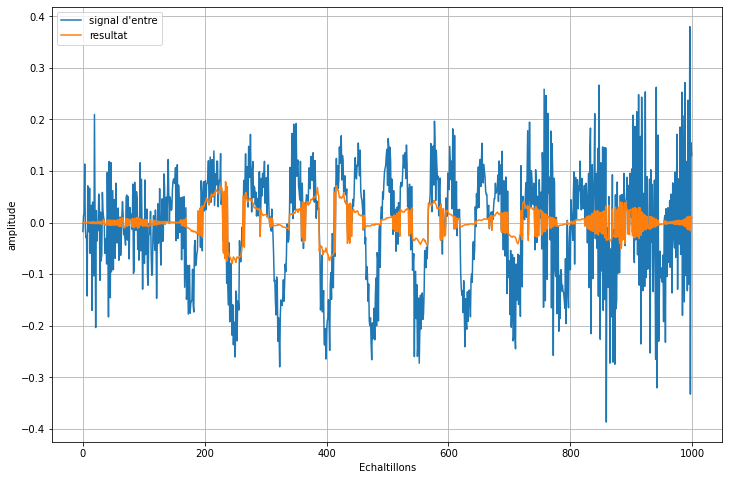

In [271]:
plt.figure(figsize=(12,8))#VISULALISATION DE QUELQUE ECHANTILLONS SINGNAL D'ENTRÉE ET LE RESULTAT 
plt.plot(data[32000:33000], label="signal d'entre")
plt.plot(signal[32000:33000],label='resultat')
plt.grid()
plt.legend()
plt.xlabel("Echaltillons")
plt.ylabel("amplitude")
display(Audio(signal,rate=samplerate))
display(Audio(data,rate=samplerate))